In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from systems.Fields.scalar_field import Scalar_Field
from systems.Fields.phi4 import Phi4
from flows.NormalizingFlow import NormalizingFlow    
from lattice import Lattice
torch.set_default_dtype(torch.float32)
#torch.set_float32_matmul_precision('high')

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_random_seed(42)


L = 8
latt = Lattice([L,L,L,L],[16,16,16,16],device=device)



sf = Scalar_Field(latt,1)
phi_4 = Phi4(latt,1,1/24)


o=latt.ort_mat
print(o.shape)

#sf.set_J_local(0,[0,L//2])
#phi_4.set_J_local(1,[0,L//2])




torch.Size([4096, 4096])


In [5]:
normal_dist = latt.normal_sampler()
train_loader = latt.get_train_loader(epoch_size = 2**18,batch_size = 2 ** 4)

In [6]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        latent,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        
        super().__init__()
        self.model = model

        self.loss = criterion.to(device)
        self.latent = latent
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs
        
    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.model.parameters(), **self.optimizer_kwargs)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-5,
            factor=0.99,
            mode = "min",
            patience = 2
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch.to(device)
        latent_log_prob = torch.sum(self.model.lattice.log_prob(z),-1)
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        ess = self.loss.ESS(latent_log_prob,log_abs_det)

        
        sch = self.lr_schedulers()
        sch.step(loss)
        self.log('train_loss', loss,prog_bar=True)
        self.log('ess',ess)
        self.log('mean_x',torch.mean(x))
        self.log('lr',sch.get_last_lr()[0])
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [7]:
set_random_seed(42)
nf = NormalizingFlow.config_and_init(n_blocks = 2,num_hidden = 6,hidden_dim = latt.total_nodes//2,lattice=latt,ort=True)

In [8]:
nf = NormalizingFlow.load_model("./weights/field.pth").to(device)

In [9]:
z=next(iter(train_loader))
print(nf.g_f_test(z))

(tensor(0.0014, device='cuda:0'), tensor(0.0006, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>))


In [10]:

set_random_seed(42)


pipeline = Pipeline(model = nf, 
                  latent = normal_dist ,
                  criterion = sf.get_KL(), 
                  optimizer_class=torch.optim.Adam,
                  optimizer_kwargs={"lr": 0.001,"weight_decay":1}).to(device)

trainer = pl.Trainer(
        max_epochs = 100,
        logger = TensorBoardLogger(save_dir=f"./logs/field"),
        num_sanity_val_steps = 0,
        log_every_n_steps = 1,
        enable_checkpointing = False,
        accumulate_grad_batches = 1)

#trainer.fit(model=pipeline, train_dataloaders = train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
try: 
    trainer.fit(model=pipeline, train_dataloaders = train_loader)
except Exception:
    nf.save("./weights/field.pth")
    

You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | NormalizingFlow | 302 M  | train
1 | loss  | KL_with_S       | 0      | train
--------------------------------------------------
302 M     Trainable params
0         Non-trainable params
302 M     Total params
1,209.336 Total estimated model params size (MB)
235       Modules in train mode
0         Modules in eval mode
/home/seva/PIMC/PIMC/PIMC-py/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does 

Epoch 0:   0%|          | 0/16384 [00:00<?, ?it/s] 

/home/seva/PIMC/PIMC/PIMC-py/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  current = float(metrics)


Epoch 0:  16%|█▌        | 2653/16384 [06:35<34:05,  6.71it/s, v_num=27, train_loss=30.90]  


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/home/seva/PIMC/PIMC/PIMC-py/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [19]:
nf = NormalizingFlow.load_model("./weights/field.pth").to(device)
nf.eval()

NormalizingFlow(
  (flows): ModuleList(
    (0-7): 8 x AffineCouplingLayer(
      (theta): ThetaNetwork(
        (input): Linear(in_features=128, out_features=512, bias=True)
        (hidden): ModuleList(
          (0-5): 6 x Sequential(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Dropout(p=0, inplace=False)
            (2): LayerNorm((np.int64(512),), eps=1e-05, elementwise_affine=True)
          )
        )
        (dims): Linear(in_features=512, out_features=256, bias=True)
      )
    )
  )
)

In [ ]:
"""
z = normal_dist.sample((1000,)).to(device)
with torch.no_grad():
    phi, _ = nf.g(z)
err = torch.std(phi)    
phi = torch.mean(phi,0)

prop_x = sf.get_free_prop_x() 
phi_theor = -torch.matmul(prop_x,sf.J)
print(torch.mean(phi-phi_theor),err/(1000 ** 0.5))
"""


tensor(0.0047, device='cuda:0') tensor(0.0106, device='cuda:0')


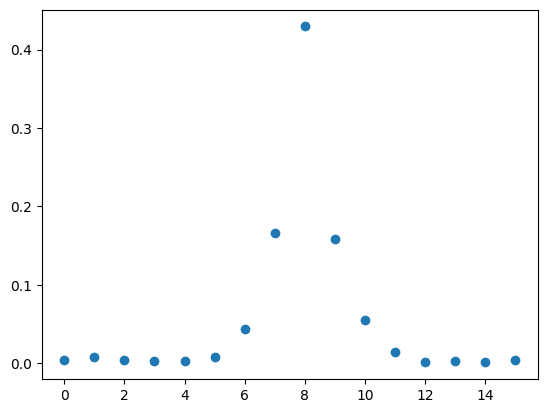

In [ ]:
"""
z = normal_dist.sample((100,)).to(device)
with torch.no_grad():
    phi, _ = nf.g(z)
phi = torch.mean(phi,0)

av = sf.lattice.get_time_averaging_mat()
phi = torch.matmul(av,phi)

plt.figure()
plt.scatter(np.arange(sf.lattice.n_nodes[1]),-phi.cpu())
plt.show()
"""